# Inpainting with homogeneous diffusion 
We will use the inpainting with Homogeneous diffusion to interpolate in a grid. The method is described in https://arxiv.org/pdf/1506.04566.pdf. We consider the following PDE with mixed boundary conditions
$$\begin{align}
\nabla u &= 0 \text{ on } \Omega \setminus \Omega_{K}\,, \\
u &= f  \text{ on } \Omega_K \,, \\
\partial_n u &= 0 \text{ on } \partial \Omega \setminus \partial \Omega_K\,.
\end{align}$$

Here $ \partial_n u $ denotes the outward normal.

We will now try to use Laplace interpolation on an 1D problem. We will use the following function:

$f(x) = \exp{(2x -3)} + x\,,\quad x\in [-4, 4]\, $.

In [27]:
using Laplacians, LinearAlgebra, SparseArrays
using TestImages, Colors, Plots, FileIO

In [28]:
x_array = -4:0.08:4;
x_array = collect(x_array);
N = length(x_array);
f_array = exp.(2*x_array .- 3) + x_array;
discard = rand(2:100, 30);
discard = unique(discard);
all = collect(1:length(x_array));
keep = setdiff(all, discard);
length(keep);

In [29]:
#Constructing the Laplace matrix
h = 0.08;
ev = 1/h^2*ones(N-1,1);
dv = -ones(N,1)*2/h^2
A = Tridiagonal([fill(1.0/h^2, N-2); 0.0], [1.0; fill(-2.0/h^2, N-2); 1.0], [0.0; fill(1.0/h^2, N-2);]);

In [30]:
#Constructing C
diag_c = ones(N);
diag_c[discard] .= 0;
C = diagm(diag_c);
Id = Matrix(1.0I, N,N);

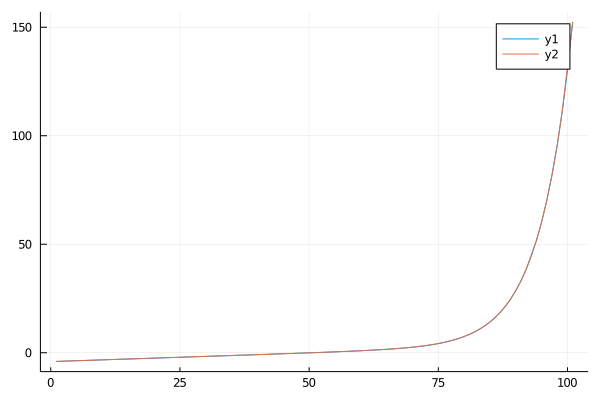

In [31]:
u = (C-(Id -C)*A)\(C*f_array);
pa = plot(f_array)
plot!(pa, u)


In [32]:
#Verifying if the second derivative at the discarded points is 0
(A*u)[discard]

26-element Array{Float64,1}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
 -1.4210854715202004e-14
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  5.684341886080802e-14
  0.0
  0.0
  0.0
  0.0
 -5.684341886080802e-14
  0.0
 -5.684341886080802e-14
  0.0
  0.0
  0.0
  0.0

# 2D Example
We will use the Mandrill image to test the approach.


In [33]:
img = testimage("mandrill");
imgg = Gray.(img);
mat = convert(Array{Float64}, imgg)[1:256,1:512];
# This image is square
#plot(imgg)

In [34]:
rows = size(mat,1);
columns = size(mat,2);
BoundaryNodes1 = collect(1:rows);
BoundaryNodes2 = collect(rows+1:rows:rows*columns-rows+1);
BoundaryNodes3 = collect(rows*columns-rows+2:rows*columns);
BoundaryNodes4 = collect(2*rows:rows:(columns-1)*rows);
BoundaryNodes= union(BoundaryNodes1, BoundaryNodes2, BoundaryNodes3, BoundaryNodes4);
AllNodes = collect(1:rows*columns)
NonBoundaryNodes = setdiff(AllNodes, BoundaryNodes);
size(NonBoundaryNodes)

(129540,)

In [35]:
#Now we discard about 50% of the non boundary nodes
No_of_nodes_discarded = 60000
discard = rand(1:length(NonBoundaryNodes), No_of_nodes_discarded);
discard = unique(discard);
discard = NonBoundaryNodes[discard];

In [36]:
#Constructing the 2D Laplace matrix
function spdiagm_nonsquare(m, n, args...)
    I, J, V = SparseArrays.spdiagm_internal(args...)
    return sparse(I, J, V, m, n)
end

# returns -∇² (discrete Laplacian, real-symmetric positive-definite) on n₁×n₂ grid
function ∇²(n₁,n₂)
    o₁ = ones(n₁)
    ∂₁ = spdiagm_nonsquare(n₁+1,n₁,-1=>-o₁,0=>o₁)
    o₂ = ones(n₂)
    ∂₂ = spdiagm_nonsquare(n₂+1,n₂,-1=>-o₂,0=>o₂)
    return kron(sparse(I,n₂,n₂), ∂₁'*∂₁) + kron(∂₂'*∂₂, sparse(I,n₁,n₁))
end

∇² (generic function with 1 method)

In [37]:
A = ∇²(rows,columns)

131072×131072 SparseMatrixCSC{Float64,Int64} with 653824 stored entries:
  [1     ,      1]  =  4.0
  [2     ,      1]  =  -1.0
  [257   ,      1]  =  -1.0
  [1     ,      2]  =  -1.0
  [2     ,      2]  =  4.0
  [3     ,      2]  =  -1.0
  [258   ,      2]  =  -1.0
  [2     ,      3]  =  -1.0
  [3     ,      3]  =  4.0
  [4     ,      3]  =  -1.0
  [259   ,      3]  =  -1.0
  [3     ,      4]  =  -1.0
  ⋮
  [131069, 131069]  =  4.0
  [131070, 131069]  =  -1.0
  [130814, 131070]  =  -1.0
  [131069, 131070]  =  -1.0
  [131070, 131070]  =  4.0
  [131071, 131070]  =  -1.0
  [130815, 131071]  =  -1.0
  [131070, 131071]  =  -1.0
  [131071, 131071]  =  4.0
  [131072, 131071]  =  -1.0
  [130816, 131072]  =  -1.0
  [131071, 131072]  =  -1.0
  [131072, 131072]  =  4.0

In [38]:
#Enforcing Dirichlet Boundary conditions
A[BoundaryNodes,:] .= 0
A[:,BoundaryNodes] .= 0
A[BoundaryNodes, BoundaryNodes] = sparse(I, length(BoundaryNodes), length(BoundaryNodes));
A

131072×131072 SparseMatrixCSC{Float64,Int64} with 653824 stored entries:
  [1     ,      1]  =  1.0
  [2     ,      1]  =  0.0
  [257   ,      1]  =  0.0
  [1     ,      2]  =  0.0
  [2     ,      2]  =  1.0
  [3     ,      2]  =  0.0
  [258   ,      2]  =  0.0
  [2     ,      3]  =  0.0
  [3     ,      3]  =  1.0
  [4     ,      3]  =  0.0
  [259   ,      3]  =  0.0
  [3     ,      4]  =  0.0
  ⋮
  [131069, 131069]  =  1.0
  [131070, 131069]  =  0.0
  [130814, 131070]  =  0.0
  [131069, 131070]  =  0.0
  [131070, 131070]  =  1.0
  [131071, 131070]  =  0.0
  [130815, 131071]  =  0.0
  [131070, 131071]  =  0.0
  [131071, 131071]  =  1.0
  [131072, 131071]  =  0.0
  [130816, 131072]  =  0.0
  [131071, 131072]  =  0.0
  [131072, 131072]  =  1.0

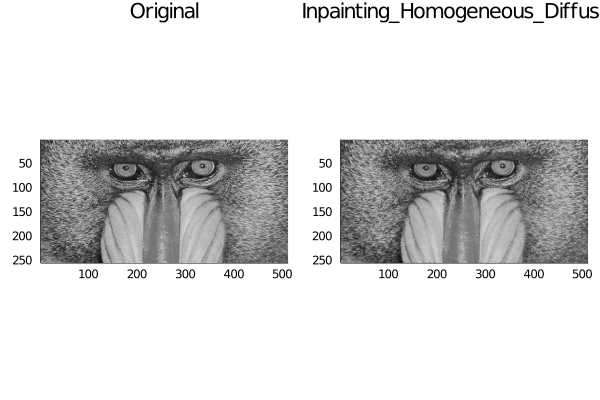

In [46]:
#Constructing C
C = sparse(I, rows*columns, rows*columns)
C[discard,discard] .= 0
Id = sparse(I, rows*columns,rows*columns);
f = mat[:];
u =((C-(Id -C)*A)) \ (C*f);
restored_img = reshape(u, size(mat,1), size(mat,2));
pa = plot(Gray.(restored_img), title="Inpainting_Homogeneous_Diffusion")
plot(plot(imgg[1:size(mat,1),1:size(mat,2)], title="Original"),pa,  layout = (1,2))

In [43]:
A_new  = ∇²(rows,columns);
sum((A_new*u)[discard] .< 1e-6) == length(discard)

true

In [48]:
norm(mat[:] - u)

19.460227442894453

# Adding holes to the Mandrill Image

In [49]:
cent = [(100, 200), (200, 100), (400, 200)]
c = cent[1]
rad = 20

L = 1:size(mat,1)
K = 1:size(mat,2)

mask = ones(size(mat))
mask = broadcast(+, (L .- c[1]).^2, (K .- c[2])'.^2) .> rad^2

keep = collect(1:prod(size(mat)))

fun(c, k) = filter(x -> (floor(x/size(mat,1)) .- c[1]).^2 + (x%size(mat,1) .- c[2])'.^2 > rad^2, k)

keep = fun(cent[1], keep)
keep = fun(cent[2], keep)
keep = fun(cent[3], keep)

prod(size(mask)) - sum(mask[keep]), 2*20^2*pi

(3812, 2513.2741228718346)

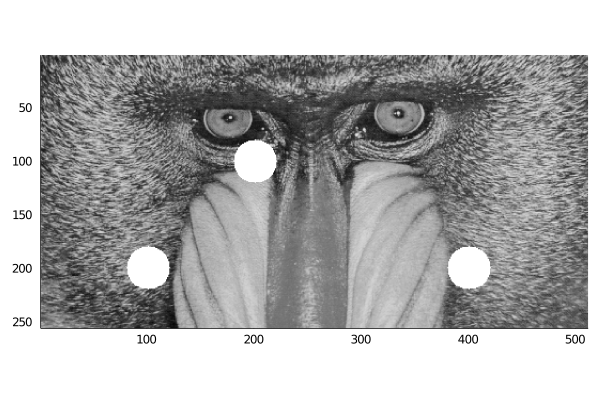

In [51]:
S = [i*size(mat,2)+j for i in 0:(size(mat,1)-1) for j in 1:size(mat,2)]
vals = mat[:]
holeyimage = ones(size(mat,1),size(mat,2))
holeyimage[S[keep]] = vals[keep]
plot(Gray.(holeyimage))

In [56]:
discard = setdiff(AllNodes, keep)

3771-element Array{Int64,1}:
  20680
  20930
  20931
  20932
  20933
  20934
  20935
  20936
  20937
  20938
  20939
  20940
  20941
      ⋮
 107460
 107461
 107462
 107463
 107464
 107465
 107466
 107467
 107468
 107469
 107470
 107720

  0.062394 seconds (103 allocations: 84.275 MiB, 12.76% gc time)


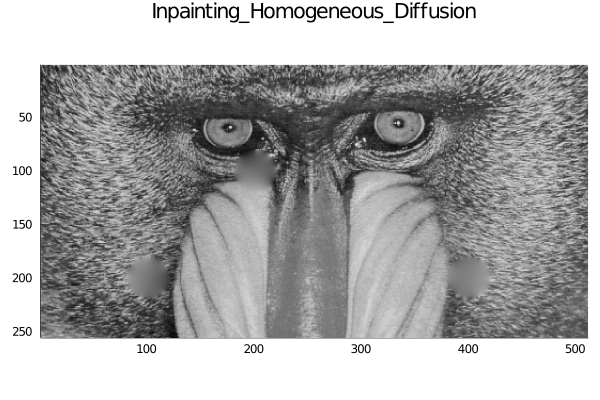

In [62]:
C = sparse(I, rows*columns, rows*columns)
C[discard,discard] .= 0
Id = sparse(I, rows*columns,rows*columns);
f = mat[:];
@time u =((C-(Id -C)*A)) \ (C*f);
restored_img = reshape(u, size(mat,1), size(mat,2));
plot(Gray.(restored_img), title="Inpainting_Homogeneous_Diffusion")


In [63]:
sum((A_new*u)[discard] .< 1e-6) == length(discard)

true